In [1]:
import sys
import os

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/2025_data"))
sys.path.append(os.path.abspath("/eos/home-d/dcostasr/SWAN_projects/NiCf/offline_trigger"))
sys.path.append('/eos/home-d/dcostasr/SWAN_projects/software/hipy')
sys.path.append("/eos/home-d/dcostasr/SWAN_projects/software/wcte_software/")

import hipy.pltext       as pltext
import hipy.utils        as ut
import matplotlib.pyplot as plt
import awkward           as ak
import numpy             as np
import matplotlib.colors as colors

from src.read_data                   import load_concatenated, read_parquet, nHits
from tqdm.notebook                   import tqdm
from WCTE_event_display.EventDisplay import EventDisplay
from scipy.special                   import factorial


%load_ext autoreload
%autoreload 2

pltext.style()

## Read Data

In [ ]:
# ============= LOADS THE DATA ===================
bkg_run  = 2384
bkg_data = load_concatenated(outdir=f"/eos/home-d/dcostasr/SWAN_projects/AmBe/tmp_parquet/{bkg_run}_calibrated")
print("Data Loaded")

# =============== MASK OUT CARDS 130-132 ===================
bkg_run_cards, bkg_run_channels, bkg_run_slots, bkg_run_positions, bkg_run_times, bkg_run_events, bkg_run_charges, bkg_run_window_times = read_parquet(bkg_data, mask=True)
print("Data Masked")

bkg_run_times_sorted = ak.sort(bkg_run_times) - bkg_run_window_times
bkg_run_window_times_sorted = ak.sort(bkg_run_window_times, axis=0)

Data Loaded


In [ ]:
# ============= LOADS THE DATA ===================
ambe_run  = 2386
ambe_data = load_concatenated(outdir=f"/eos/home-d/dcostasr/SWAN_projects/AmBe/tmp_parquet/{ambe_run}_calibrated")
print("Data Loaded")

# =============== MASK OUT CARDS 130-132 ===================
ambe_run_cards, ambe_run_channels, ambe_run_slots, ambe_run_positions, ambe_run_times, ambe_run_events, ambe_run_charges, ambe_run_window_times = read_parquet(ambe_data, mask=True)
print("Data Masked")

ambe_run_times_sorted = ak.sort(ambe_run_times) - ambe_run_window_times
ambe_run_window_times_sorted = ak.sort(ambe_run_window_times, axis=0)

Data Loaded
Data Masked


# Functions

In [ ]:
def rms(data):
    return np.sqrt(np.mean((data - np.mean(data))**2))

# Check Readout Windows

In [ ]:
subplot = pltext.canvas(8)

for i,event in enumerate(range(8)):
    subplot(i+1)
    pltext.hist(ambe_run_times_sorted[event], 100, label=f"Event {event}");
    plt.title(f"Readout Window: {(ambe_run_times_sorted[event][-1] - ambe_run_times_sorted[event][0])*1e-3:.1f} $\mu$s")

In [20]:
len(ambe_run_times_sorted[0])

906

In [ ]:
bkg__no_hits_perRW = ak.count(bkg_run_times_sorted, axis=-1)
ambe_no_hits_perRW = ak.count(ambe_run_times_sorted, axis=-1)

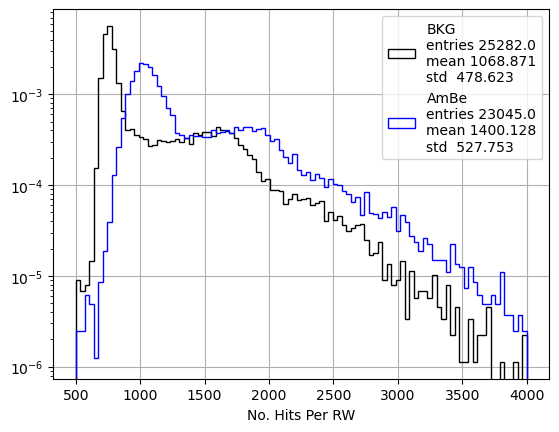

In [31]:
pltext.hist(bkg_no_hits_perRW,  100, density=True, ylog=True, range=(500, 4e3), xylabels="No. Hits Per RW", label="BKG");
pltext.hist(ambe_no_hits_perRW, 100, density=True, ylog=True, range=(500, 4e3), xylabels="No. Hits Per RW", label="AmBe");

In [34]:
(1400/270e-6)/2000, (1000/270e-6)/2000

(2592.592592592592, 1851.851851851852)

In [ ]:
bkg__total_charge_perRW = ak.sum(bkg_run_charges, axis=-1)
ambe_total_charge_perRW = ak.sum(ambe_run_charges, axis=-1)

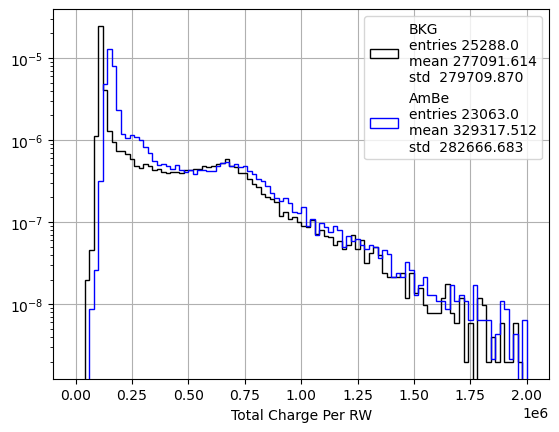

In [39]:
pltext.hist(bkg_total_charge_perRW,  100, density=True, ylog=True, range=(0, 0.20e7), xylabels="Total Charge Per RW", label="BKG");
pltext.hist(ambe_total_charge_perRW, 100, density=True, ylog=True, range=(0, 0.20e7), xylabels="Total Charge Per RW", label="AmBe");

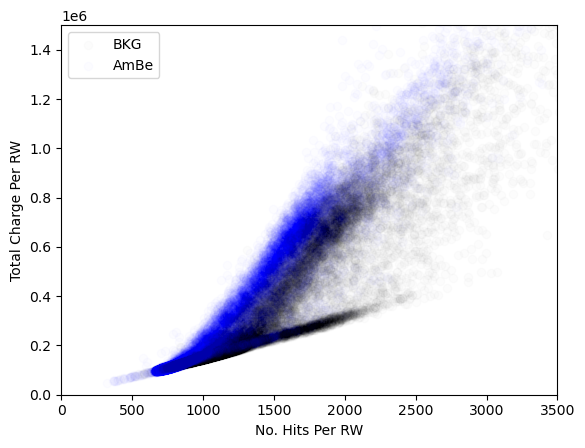

In [46]:
plt.scatter(ambe_no_hits_perRW, ambe_total_charge_perRW, alpha=0.01, label="BKG");
plt.scatter(bkg_no_hits_perRW, bkg_total_charge_perRW,   alpha=0.01, label="AmBe");

plt.xlabel("No. Hits Per RW");
plt.ylabel("Total Charge Per RW");

plt.xlim(0, 3500);
plt.ylim(0, 1.5e6);

plt.legend();

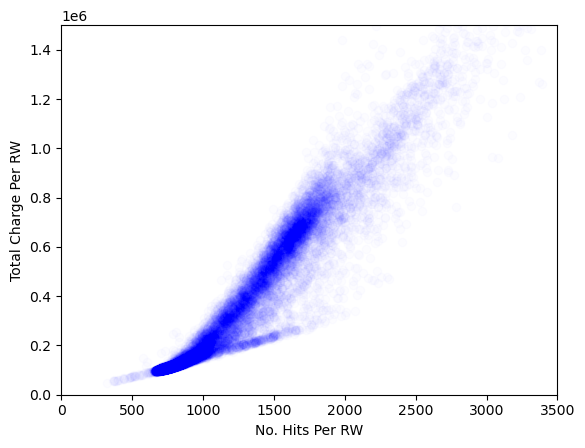

In [47]:
plt.scatter(bkg_no_hits_perRW, bkg_total_charge_perRW, alpha=0.01, color="blue");

plt.xlabel("No. Hits Per RW");
plt.ylabel("Total Charge Per RW");

plt.xlim(0, 3500);
plt.ylim(0, 1.5e6);

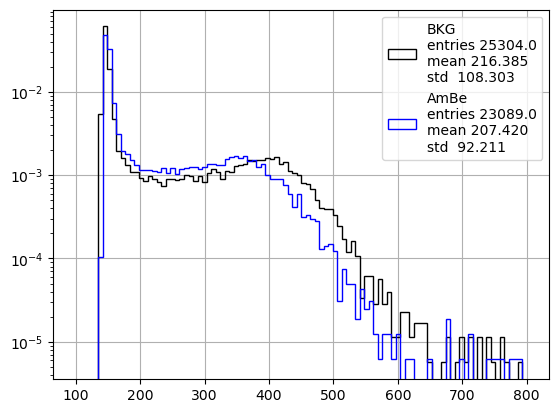

In [56]:
pltext.hist(bkg_total_charge_perRW/bkg_no_hits_perRW,   100, ylog=True, range=(100, 800), density=True, label="BKG");
pltext.hist(ambe_total_charge_perRW/ambe_no_hits_perRW, 100, ylog=True, range=(100, 800), density=True, label="AmBe");

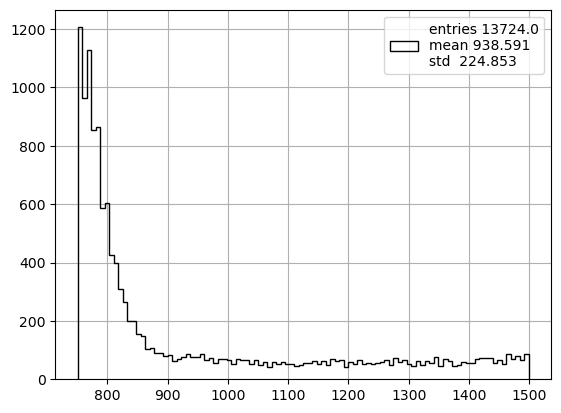

In [ ]:
pltext.hist(bkg_no_hits_perRW[(bkg_no_hits_perRW > 750) & (bkg_no_hits_perRW < 1500)], 100);

# nHits To Find Spills and AfterPulsing

In [ ]:
bkg__triggered_spill_hits_index, bkg__triggered_spill_hit_times = nHits(mode="multiple_events", hit_times=bkg_run_times_sorted,  w=5000, thresh_min=300, thresh_max=10000, pre_window=0, post_window=4000, jump=9000)
ambe_triggered_spill_hits_index, ambe_triggered_spill_hit_times = nHits(mode="multiple_events", hit_times=ambe_run_times_sorted, w=5000, thresh_min=300, thresh_max=10000, pre_window=0, post_window=4000, jump=9000)

  0%|          | 0/25315 [00:00<?, ?it/s]

100%|██████████| 22892/22892 [00:04<00:00, 4709.57it/s]


### Produce nHits_Spills.pdf With Event Display Too

In [11]:
from matplotlib.backends.backend_pdf import PdfPages
from itertools import islice

with PdfPages("./bkg_nHits_Spills_Hist.pdf") as pdf:
    for key, value in tqdm(islice(bkg_triggered_spill_hits_index.items(), 100), total=100):
        
        event = key
        data = bkg_run_times_sorted[event]
        pltext.hist(data                                                           , 100, range=(data[0], data[-1]), label=f"Event {event}");
        pltext.hist(data[np.concatenate(bkg_triggered_spill_hits_index.get(event))], 100, range=(data[0], data[-1]), label="Triggered Hits");
        
        plt.title(f"Readout Window: {(data[-1] - data[0])*1e-3:.1f} $\mu$s")

        pdf.savefig()  
        plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

### Cantas Veces Trigga O Algoritmo Para Os Spills?

In [6]:
bkg_total_no_triggers  = [len(bkg_triggered_spill_hits_index.get(key)) for key, value in bkg_triggered_spill_hits_index.items()]
ambe_total_no_triggers = [len(ambe_triggered_spill_hits_index.get(key)) for key, value in ambe_triggered_spill_hits_index.items()]

In [7]:
np.sum(bkg_total_no_triggers), np.sum(ambe_total_no_triggers)

(9730, 9510)

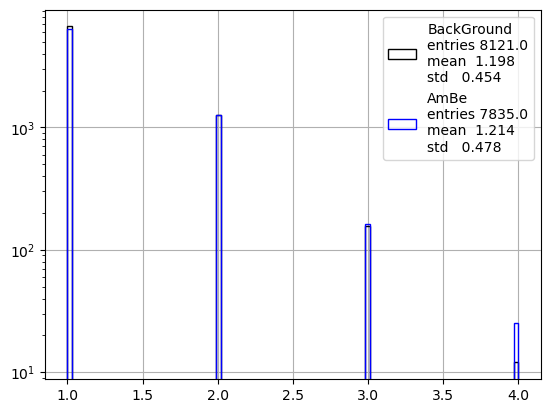

In [8]:
pltext.hist(bkg_total_no_triggers, 100, ylog=True, label="BackGround");
pltext.hist(ambe_total_no_triggers, 100, ylog=True, label="AmBe");

In [9]:
thresholds = np.arange(100, 1010, 10)
sum_bkg  = []
sum_ambe = []

for th in tqdm(thresholds, total=len(thresholds)):
    bkg_triggered_spill_hits_index  = nHits(mode="multiple_events", hit_times=bkg_run_times_sorted,  w=5000, thresh_min=th, thresh_max=10000, pre_window=0, post_window=4000, jump=9000, progress_bar=False)
    ambe_triggered_spill_hits_index = nHits(mode="multiple_events", hit_times=ambe_run_times_sorted, w=5000, thresh_min=th, thresh_max=10000, pre_window=0, post_window=4000, jump=9000, progress_bar=False)

    bkg_total_no_triggers  = [len(bkg_triggered_spill_hits_index.get(key)) for key, value in bkg_triggered_spill_hits_index.items()]
    ambe_total_no_triggers = [len(ambe_triggered_spill_hits_index.get(key)) for key, value in ambe_triggered_spill_hits_index.items()]

    sum_bkg.append(np.sum(bkg_total_no_triggers))
    sum_ambe.append(np.sum(ambe_total_no_triggers))

  0%|          | 0/91 [00:00<?, ?it/s]

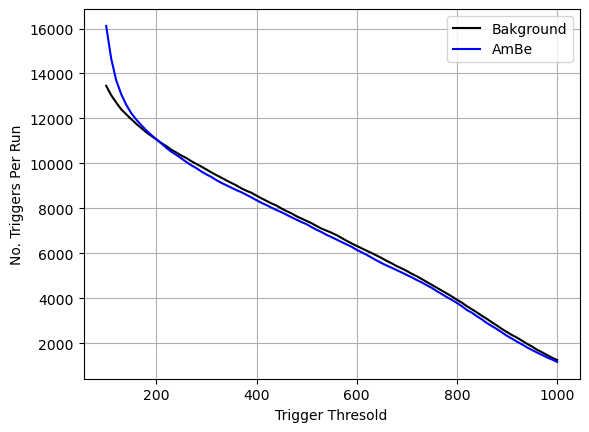

In [10]:
plt.plot(thresholds, sum_bkg,  label="Bakground");
plt.plot(thresholds, sum_ambe, label="AmBe");

plt.xlabel("Trigger Thresold")
plt.ylabel("No. Triggers Per Run")

plt.grid(True)

# plt.vlines(200, 9000, 18000, color="r", linestyle="-.")
# plt.ylim(9300, 16300);
plt.legend();

### Studies Without Applying The nHits Algorithm

In [13]:
bkg_no_hits_per_bin  = np.concatenate([np.histogram(bkg_run_times_sorted[ev],  30)[0] for ev in tqdm(range(len(bkg_run_times_sorted)),  total=len(bkg_run_times_sorted))])
ambe_no_hits_per_bin = np.concatenate([np.histogram(ambe_run_times_sorted[ev], np.arange(0,270e3,9e3))[0] for ev in tqdm(range(len(ambe_run_times_sorted)), total=len(ambe_run_times_sorted))])

  0%|          | 0/25315 [00:00<?, ?it/s]

  0%|          | 0/23094 [00:00<?, ?it/s]

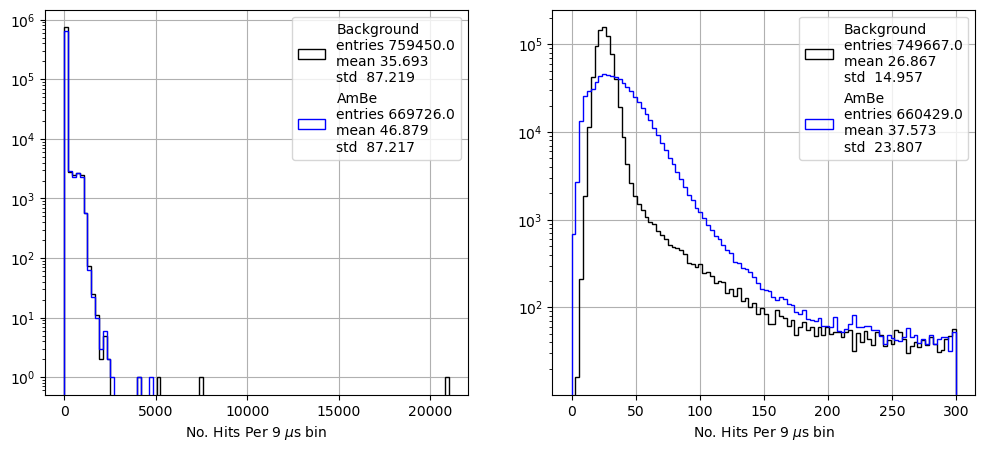

In [14]:
subplot = pltext.canvas(2)

subplot(1)
pltext.hist(bkg_no_hits_per_bin, 100,  ylog=True, range=(0, 21e3), xylabels="No. Hits Per 9 $\mu$s bin", label="Background");
pltext.hist(ambe_no_hits_per_bin, 100, ylog=True, range=(0, 21e3), xylabels="No. Hits Per 9 $\mu$s bin", label="AmBe");

subplot(2)
pltext.hist(bkg_no_hits_per_bin, 100,  ylog=True, range=(0, 300), xylabels="No. Hits Per 9 $\mu$s bin", label="Background");
pltext.hist(ambe_no_hits_per_bin, 100, ylog=True, range=(0, 300), xylabels="No. Hits Per 9 $\mu$s bin", label="AmBe");

In [15]:
ak.argmax(bkg_no_hits_per_bin)

198632

In [16]:
len(bkg_no_hits_per_bin)

759450

In [20]:
np.histogram(bkg_run_times_sorted[0], 30)[0]

<Array [24, 18, 27, 18, 22, 23, ..., 46, 23, 31, 27, 24] type='30 * float64'>

### Studies Applying The nHits Algorithm. Characterization Of The Spill Triggered Signal.
Non sei se isto paga moito a pena

In [ ]:
def spill_characterization(trigger_indices, data):
    no_spill_hits     = []
    spill_pulse_width = []
    for key, values in tqdm(trigger_indices.items(), total=len(trigger_indices.items())):
        event_data = data[key]
        for i in trigger_indices.get(key):
            triggered_hits = event_data[trigger_indices.get(key)[0]]

            no_spill_hits    .append(len(triggered_hits)) 
            spill_pulse_width.append(triggered_hits[-1] - triggered_hits[0])
    
    return no_spill_hits, spill_pulse_width

: 

In [ ]:
bkg_no_spill_hits, bkg_spill_pulse_width   = spill_characterization( bkg_triggered_spill_hits_index,  bkg_run_times_sorted)
ambe_no_spill_hits, ambe_spill_pulse_width = spill_characterization(ambe_triggered_spill_hits_index, ambe_run_times_sorted)

: 

In [ ]:
subplot = pltext.canvas(2)

subplot(1)
pltext.hist(bkg_no_spill_hits,  100, ylog=True, xylabels="No. Spill Hits Per Trigger", density=True, stacked=True, label="Background");
pltext.hist(ambe_no_spill_hits, 100, ylog=True, xylabels="No. Spill Hits Per Trigger", density=True, stacked=True, label="Ambe");

subplot(2)
pltext.hist(bkg_spill_pulse_width,  100, xylabels="Spill Light Pulse Width", density=True, stacked=True, label="Background");
pltext.hist(ambe_spill_pulse_width, 100, xylabels="Spill Light Pulse Width", density=True, stacked=True, label="AmBe");

: 

### Remove Spills from data

In [8]:
def remove_spill(trigger_indices, run_times):
    noSpill_hit_times = []
    for key, value in tqdm(trigger_indices.items(), total=len(trigger_indices)):
        data  = run_times[key]
        trigger_indices_event = np.concatenate(trigger_indices.get(key))
        all_indices           = np.arange(len(data))
        invalid_indices       = np.setdiff1d(all_indices, trigger_indices_event)
        noSpill_hit_times.append(data[invalid_indices])

    noSpill_hit_times = ak.Array(noSpill_hit_times)

    total_events = np.arange(len(run_times))
    spill_events = [key for key,value in trigger_indices.items()]

    noSpill_events = [i for i in total_events if i not in spill_events]

    corrected_run_times_sorted = ak.sort(ak.concatenate([run_times[noSpill_events], noSpill_hit_times], axis=0))

    return corrected_run_times_sorted

In [9]:
bkg__corrected_run_times_sorted = remove_spill(bkg__triggered_spill_hits_index, bkg_run_times_sorted)
ambe_corrected_run_times_sorted = remove_spill(ambe_triggered_spill_hits_index, ambe_run_times_sorted)

  0%|          | 0/8121 [00:00<?, ?it/s]

  0%|          | 0/7628 [00:00<?, ?it/s]

In [101]:
bkg__corrected_run_charge = remove_spill(bkg__triggered_spill_hits_index,  bkg_run_charges)
ambe_corrected_run_charge = remove_spill(ambe_triggered_spill_hits_index, ambe_run_charges)

  0%|          | 0/8121 [00:00<?, ?it/s]

  0%|          | 0/7628 [00:00<?, ?it/s]

# Check Data WithOut Spills Now

In [98]:
bkg__corrected_no_hits_perRW = ak.count(bkg__corrected_run_times_sorted, axis=-1)
ambe_corrected_no_hits_perRW = ak.count(ambe_corrected_run_times_sorted, axis=-1)

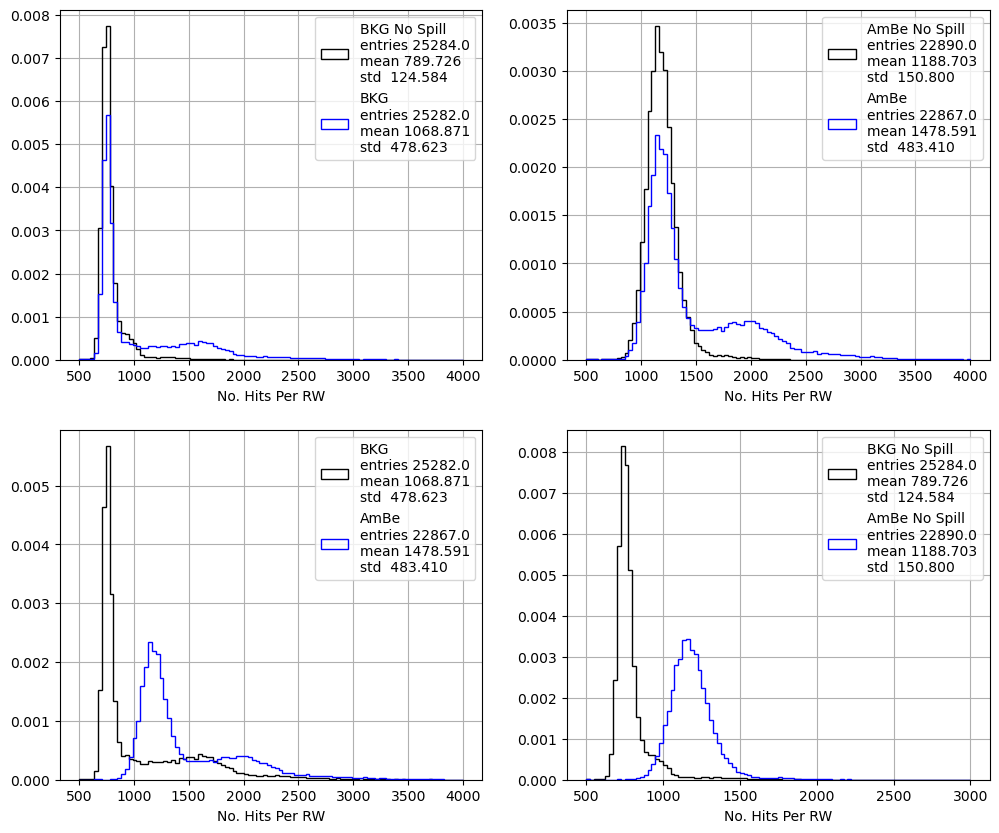

In [99]:
subplot = pltext.canvas(4)

subplot(1)
pltext.hist(bkg__corrected_no_hits_perRW, 100, density=True, ylog=False, range=(500, 4e3), xylabels="No. Hits Per RW", label="BKG No Spill");
pltext.hist(bkg__no_hits_perRW,           100, density=True, ylog=False, range=(500, 4e3), xylabels="No. Hits Per RW", label="BKG");

subplot(2)
pltext.hist(ambe_corrected_no_hits_perRW, 100, density=True, ylog=False, range=(500, 4e3), xylabels="No. Hits Per RW", label="AmBe No Spill");
pltext.hist(ambe_no_hits_perRW,           100, density=True, ylog=False, range=(500, 4e3), xylabels="No. Hits Per RW", label="AmBe");

subplot(3)
pltext.hist(bkg__no_hits_perRW,           100, density=True, ylog=False, range=(500, 4e3), xylabels="No. Hits Per RW", label="BKG");
pltext.hist(ambe_no_hits_perRW,           100, density=True, ylog=False, range=(500, 4e3), xylabels="No. Hits Per RW", label="AmBe");

subplot(4)
pltext.hist(bkg__corrected_no_hits_perRW, 100, density=True, ylog=False, range=(500, 3e3), xylabels="No. Hits Per RW", label="BKG No Spill");
pltext.hist(ambe_corrected_no_hits_perRW, 100, density=True, ylog=False, range=(500, 3e3), xylabels="No. Hits Per RW", label="AmBe No Spill");

In [102]:
bkg__corrected_total_charge_perRW = ak.sum(bkg__corrected_run_charge, axis=-1)
ambe_corrected_total_charge_perRW = ak.sum(ambe_corrected_run_charge, axis=-1)

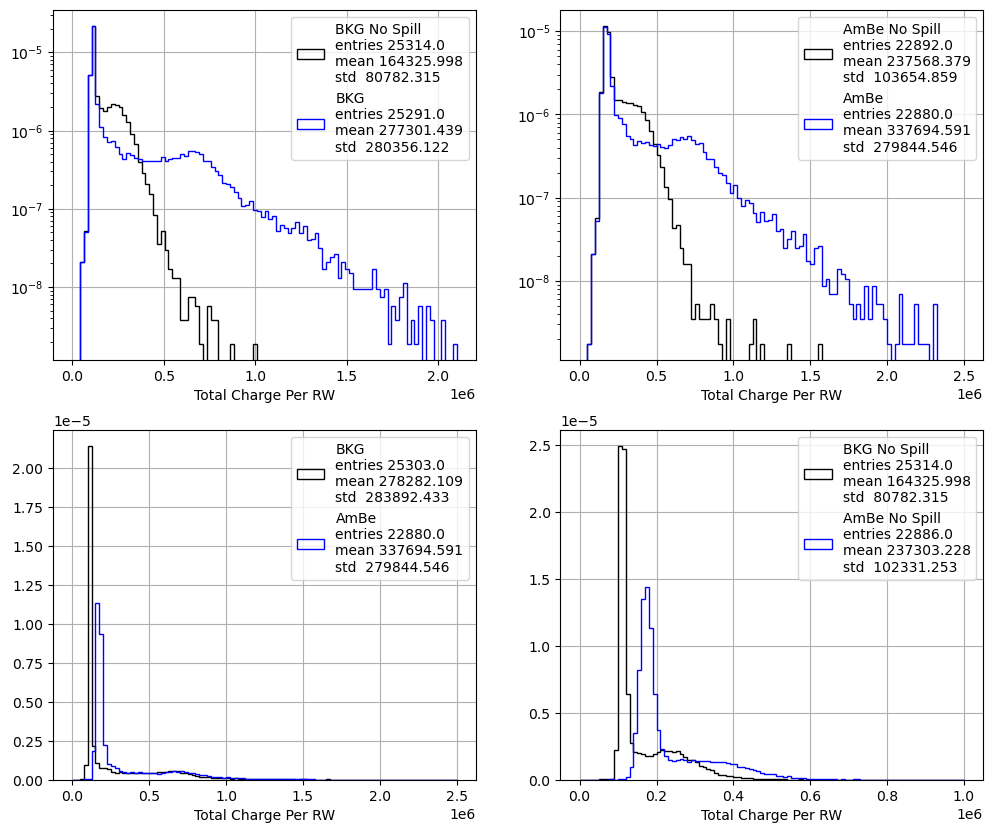

In [104]:
subplot = pltext.canvas(4)

subplot(1)
pltext.hist(bkg__corrected_total_charge_perRW, 100, range=(0, 2.1e6), ylog=True, density=True, xylabels="Total Charge Per RW", label="BKG No Spill");
pltext.hist(bkg__total_charge_perRW,           100, range=(0, 2.1e6), ylog=True, density=True, xylabels="Total Charge Per RW", label="BKG");

subplot(2)
pltext.hist(ambe_corrected_total_charge_perRW, 100, range=(0, 2.5e6), ylog=True, density=True, xylabels="Total Charge Per RW", label="AmBe No Spill");
pltext.hist(ambe_total_charge_perRW,           100, range=(0, 2.5e6), ylog=True, density=True, xylabels="Total Charge Per RW", label="AmBe");

subplot(3)
pltext.hist(bkg__total_charge_perRW,           100, range=(0, 2.5e6), ylog=False, density=True, xylabels="Total Charge Per RW", label="BKG");
pltext.hist(ambe_total_charge_perRW,           100, range=(0, 2.5e6), ylog=False, density=True, xylabels="Total Charge Per RW", label="AmBe");

subplot(4)
pltext.hist(bkg__corrected_total_charge_perRW, 100, range=(0, 1.0e6), ylog=False, density=True, xylabels="Total Charge Per RW", label="BKG No Spill");
pltext.hist(ambe_corrected_total_charge_perRW, 100, range=(0, 1.0e6), ylog=False, density=True, xylabels="Total Charge Per RW", label="AmBe No Spill");

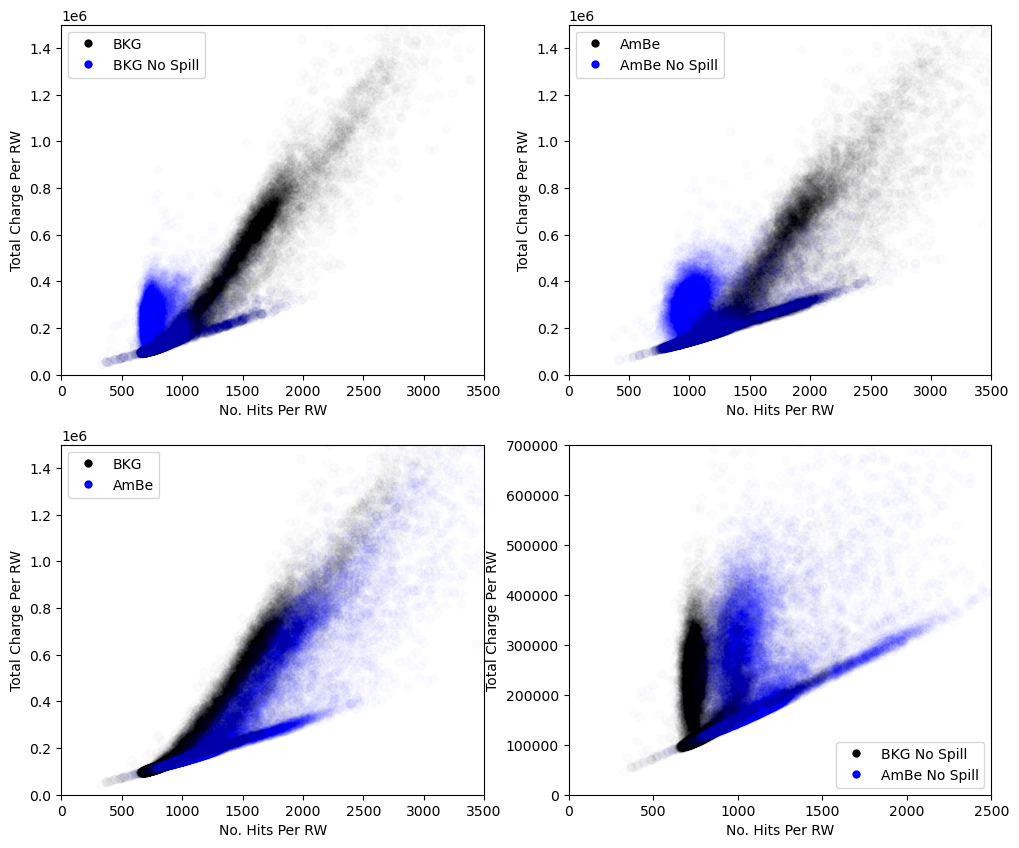

In [ ]:
from matplotlib.lines import Line2D

subplot = pltext.canvas(4)

subplot(1)
plt.scatter(bkg__no_hits_perRW, bkg__total_charge_perRW,                     alpha=0.01, label="BKG");
plt.scatter(bkg__corrected_no_hits_perRW, bkg__corrected_total_charge_perRW, alpha=0.01, label="BKG No Spill");

plt.xlabel("No. Hits Per RW");
plt.ylabel("Total Charge Per RW");

plt.xlim(0, 3500);
plt.ylim(0, 1.5e6);

# Crear handles personalizados sin alpha
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='BKG', markerfacecolor='C0', markersize=7),
    Line2D([0], [0], marker='o', color='w', label='BKG No Spill', markerfacecolor='C1', markersize=7)
]

# Añadir la leyenda
plt.legend(handles=legend_elements)

subplot(2)
plt.scatter(ambe_no_hits_perRW, ambe_total_charge_perRW,                     alpha=0.01, label="AmBe");
plt.scatter(ambe_corrected_no_hits_perRW, ambe_corrected_total_charge_perRW, alpha=0.01, label="AmBe No Spill");

plt.xlabel("No. Hits Per RW");
plt.ylabel("Total Charge Per RW");

plt.xlim(0, 3500);
plt.ylim(0, 1.5e6);

# Crear handles personalizados sin alpha
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='AmBe', markerfacecolor='C0', markersize=7),
    Line2D([0], [0], marker='o', color='w', label='AmBe No Spill', markerfacecolor='C1', markersize=7)
]

# Añadir la leyenda
plt.legend(handles=legend_elements)

subplot(3)
plt.scatter(bkg__no_hits_perRW, bkg__total_charge_perRW, alpha=0.01, label="BKG");
plt.scatter(ambe_no_hits_perRW, ambe_total_charge_perRW, alpha=0.01, label="AmBe");

plt.xlabel("No. Hits Per RW");
plt.ylabel("Total Charge Per RW");

plt.xlim(0, 3500);
plt.ylim(0, 1.5e6);

# Crear handles personalizados sin alpha
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='BKG', markerfacecolor='C0', markersize=7),
    Line2D([0], [0], marker='o', color='w', label='AmBe', markerfacecolor='C1', markersize=7)
]

# Añadir la leyenda
plt.legend(handles=legend_elements)

subplot(4)
plt.scatter(bkg__corrected_no_hits_perRW, bkg__corrected_total_charge_perRW, alpha=0.01, label="BKG No Spill");
plt.scatter(ambe_corrected_no_hits_perRW, ambe_corrected_total_charge_perRW, alpha=0.01, label="AmBe No Spill");

plt.xlabel("No. Hits Per RW");
plt.ylabel("Total Charge Per RW");

plt.xlim(0, 2500);
plt.ylim(0, 0.7e6);

# Crear handles personalizados sin alpha
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='BKG No Spill', markerfacecolor='C0', markersize=7),
    Line2D([0], [0], marker='o', color='w', label='AmBe No Spill', markerfacecolor='C1', markersize=7)
]

# Añadir la leyenda
plt.legend(handles=legend_elements)

# Scintillation 

### Studies Without And Applying The nHits Algorithm

#### 9 $\mu s$

In [53]:
bkg__mask = [(bkg__no_hits_perRW > 750) & (bkg__no_hits_perRW < 1500)]
ambe_mask = [(ambe_no_hits_perRW > 750) & (ambe_no_hits_perRW < 1500)]
bkg__no_hits_per_bin = np.concatenate([np.histogram(bkg_run_times_sorted[ev],  np.arange(0, 270e3, 9e3))[0] for ev in tqdm(range(len(bkg_run_times_sorted[bkg__mask[0]])),  total=len(bkg_run_times_sorted[bkg__mask[0]]))])
ambe_no_hits_per_bin = np.concatenate([np.histogram(ambe_run_times_sorted[ev], np.arange(0, 270e3, 9e3))[0] for ev in tqdm(range(len(ambe_run_times_sorted[ambe_mask[0]])), total=len(ambe_run_times_sorted[ambe_mask[0]]))])

  0%|          | 0/13724 [00:00<?, ?it/s]

  0%|          | 0/15298 [00:00<?, ?it/s]

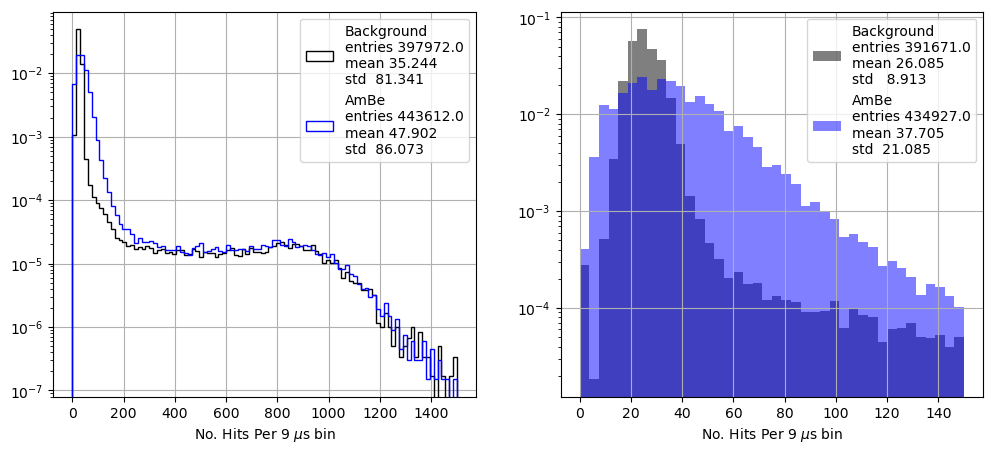

In [54]:
subplot = pltext.canvas(2)
bin_width = 9

subplot(1)
pltext.hist(bkg_no_hits_per_bin,  100, ylog=True, range=(0, 1500), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="Background");
pltext.hist(ambe_no_hits_per_bin, 100, ylog=True, range=(0, 1500), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="AmBe");

subplot(2)
pltext.hist(bkg_no_hits_per_bin,  40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="Background");
pltext.hist(ambe_no_hits_per_bin, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="AmBe");

In [82]:
bkg__mask = [(bkg__no_hits_perRW > 750) & (bkg__no_hits_perRW < 1500)]
ambe_mask = [(ambe_no_hits_perRW > 750) & (ambe_no_hits_perRW < 1500)]
bkg__corrected_no_hits_per_bin = np.concatenate([np.histogram(bkg__corrected_run_times_sorted[ev], np.arange(0, 270e3, 9e3))[0] for ev in tqdm(range(len(bkg__corrected_run_times_sorted[bkg__mask[0]])), total=len(bkg__corrected_run_times_sorted[bkg__mask[0]]))])
ambe_corrected_no_hits_per_bin = np.concatenate([np.histogram(ambe_corrected_run_times_sorted[ev], np.arange(0, 270e3, 9e3))[0] for ev in tqdm(range(len(ambe_corrected_run_times_sorted[ambe_mask[0]])), total=len(ambe_corrected_run_times_sorted[ambe_mask[0]]))])

  0%|          | 0/13724 [00:00<?, ?it/s]

  0%|          | 0/15237 [00:00<?, ?it/s]

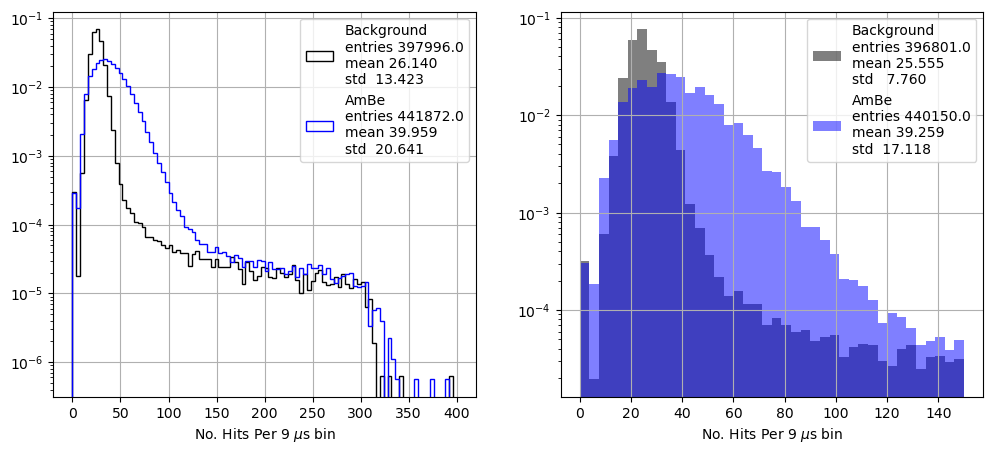

In [83]:
subplot = pltext.canvas(2)
bin_width = 9

subplot(1)
pltext.hist(bkg__corrected_no_hits_per_bin, 100, ylog=True, range=(0, 400), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="Background");
pltext.hist(ambe_corrected_no_hits_per_bin, 100, ylog=True, range=(0, 400), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="AmBe");

subplot(2)
c91, b91, _91 = pltext.hist(bkg__corrected_no_hits_per_bin, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="Background");
c92, b92, _92 = pltext.hist(ambe_corrected_no_hits_per_bin, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="AmBe");

In [84]:
bkg__rms_indices_9, bkg__rms_times_9 = nHits(mode="multiple_events", hit_times=bkg__corrected_run_times_sorted[bkg__mask[0]], w=9e3, thresh_min=45, thresh_max=120, pre_window=0, post_window=0, jump=9e3)
ambe_rms_indices_9, ambe_rms_times_9 = nHits(mode="multiple_events", hit_times=ambe_corrected_run_times_sorted[ambe_mask[0]], w=9e3, thresh_min=45, thresh_max=120, pre_window=0, post_window=0, jump=9e3)

bkg__rms_9 = []
bkg__triggered_times = bkg__rms_times_9
for k,v in tqdm(bkg__triggered_times.items(), total=len(bkg__triggered_times.items())):
    for i in bkg__triggered_times.get(k):
        bkg__rms_9.append(rms(i))

ambe_rms_9 = []
ambe_triggered_times = ambe_rms_times_9
for k,v in tqdm(ambe_triggered_times.items(), total=len(ambe_triggered_times.items())):
    for i in ambe_triggered_times.get(k):
        ambe_rms_9.append(rms(i))

100%|██████████| 15237/15237 [00:08<00:00, 1891.34it/s]


  0%|          | 0/6523 [00:00<?, ?it/s]

  0%|          | 0/15237 [00:00<?, ?it/s]

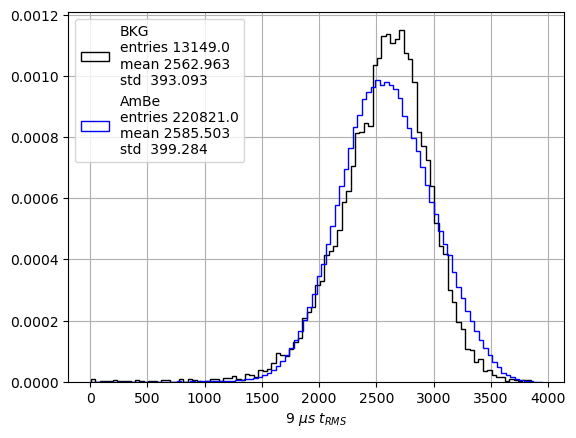

In [87]:
pltext.hist(bkg__rms_9, 100, density=True, xylabels="9 $\mu s$ $t_{RMS}$", label="BKG");
pltext.hist(ambe_rms_9, 100, density=True, xylabels="9 $\mu s$ $t_{RMS}$", label="AmBe");

#### 6 $\mu s$

In [26]:
bkg__mask = [(bkg__no_hits_perRW > 750) & (bkg__no_hits_perRW < 1500)]
ambe_mask = [(ambe_no_hits_perRW > 750) & (ambe_no_hits_perRW < 1500)]
bkg__no_hits_per_bin = np.concatenate([np.histogram(bkg_run_times_sorted[ev],  np.arange(0, 270e3, 6e3))[0] for ev in tqdm(range(len(bkg_run_times_sorted[bkg__mask[0]])),  total=len(bkg_run_times_sorted[bkg__mask[0]]))])
ambe_no_hits_per_bin = np.concatenate([np.histogram(ambe_run_times_sorted[ev], np.arange(0, 270e3, 6e3))[0] for ev in tqdm(range(len(ambe_run_times_sorted[ambe_mask[0]])), total=len(ambe_run_times_sorted[ambe_mask[0]]))])

  0%|          | 0/13724 [00:00<?, ?it/s]

  0%|          | 0/15298 [00:00<?, ?it/s]

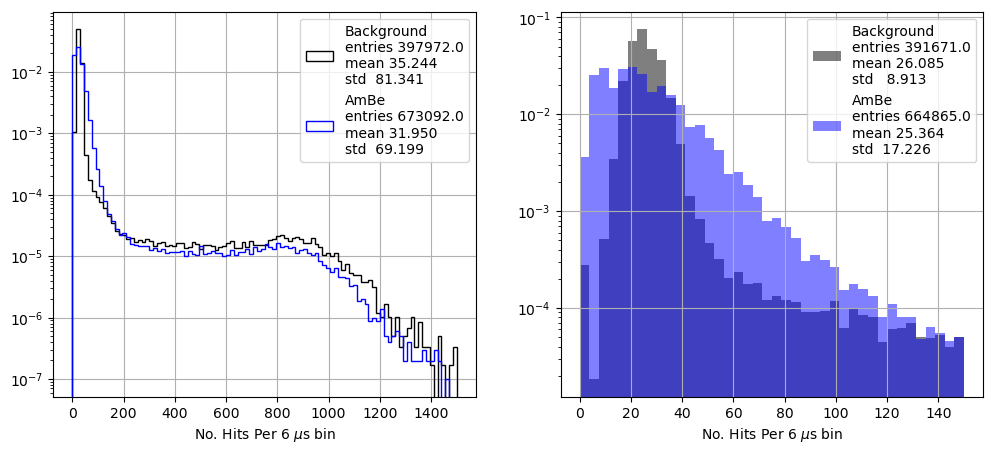

In [27]:
subplot = pltext.canvas(2)
bin_width = 6

subplot(1)
pltext.hist(bkg_no_hits_per_bin,  100, ylog=True, range=(0, 1500), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="Background");
pltext.hist(ambe_no_hits_per_bin, 100, ylog=True, range=(0, 1500), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="AmBe");

subplot(2)
pltext.hist(bkg_no_hits_per_bin,  40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="Background");
pltext.hist(ambe_no_hits_per_bin, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="AmBe");

In [77]:
bkg__mask = [(bkg__no_hits_perRW > 750) & (bkg__no_hits_perRW < 1500)]
ambe_mask = [(ambe_no_hits_perRW > 750) & (ambe_no_hits_perRW < 1500)]
bkg__corrected_no_hits_per_bin = np.concatenate([np.histogram(bkg__corrected_run_times_sorted[ev], np.arange(0, 270e3, 6e3))[0] for ev in tqdm(range(len(bkg__corrected_run_times_sorted[bkg__mask[0]])), total=len(bkg__corrected_run_times_sorted[bkg__mask[0]]))])
ambe_corrected_no_hits_per_bin = np.concatenate([np.histogram(ambe_corrected_run_times_sorted[ev], np.arange(0, 270e3, 6e3))[0] for ev in tqdm(range(len(ambe_corrected_run_times_sorted[ambe_mask[0]])), total=len(ambe_corrected_run_times_sorted[ambe_mask[0]]))])

  0%|          | 0/13724 [00:00<?, ?it/s]

  0%|          | 0/15237 [00:00<?, ?it/s]

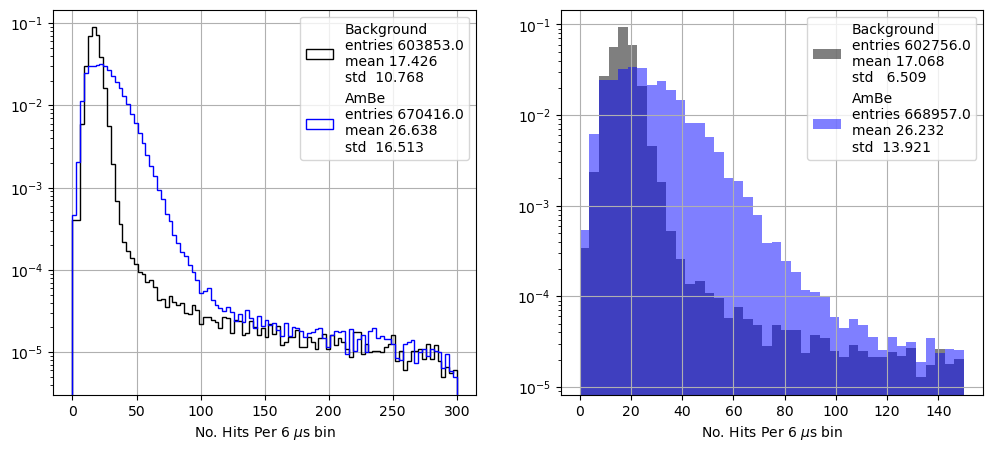

In [78]:
subplot = pltext.canvas(2)
bin_width = 6

subplot(1)
pltext.hist(bkg__corrected_no_hits_per_bin, 100, ylog=True, range=(0, 300), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="Background");
pltext.hist(ambe_corrected_no_hits_per_bin, 100, ylog=True, range=(0, 300), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="AmBe");

subplot(2)
pltext.hist(bkg__corrected_no_hits_per_bin, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="Background");
pltext.hist(ambe_corrected_no_hits_per_bin, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="AmBe");

In [80]:
bkg__rms_indices_6, bkg__rms_times_6 = nHits(mode="multiple_events", hit_times=bkg__corrected_run_times_sorted[bkg__mask[0]], w=6e3, thresh_min=35, thresh_max=110, pre_window=0, post_window=0, jump=6e3)
ambe_rms_indices_6, ambe_rms_times_6 = nHits(mode="multiple_events", hit_times=ambe_corrected_run_times_sorted[ambe_mask[0]], w=6e3, thresh_min=35, thresh_max=110, pre_window=0, post_window=0, jump=6e3)

bkg__rms_6 = []
bkg__triggered_times = bkg__rms_times_6
for k,v in tqdm(bkg__triggered_times.items(), total=len(bkg__triggered_times.items())):
    for i in bkg__triggered_times.get(k):
        bkg__rms_6.append(rms(i))

ambe_rms_6 = []
ambe_triggered_times = ambe_rms_times_6
for k,v in tqdm(ambe_triggered_times.items(), total=len(ambe_triggered_times.items())):
    for i in ambe_triggered_times.get(k):
        ambe_rms_6.append(rms(i))

  0%|          | 0/6084 [00:00<?, ?it/s]

  0%|          | 0/15237 [00:00<?, ?it/s]

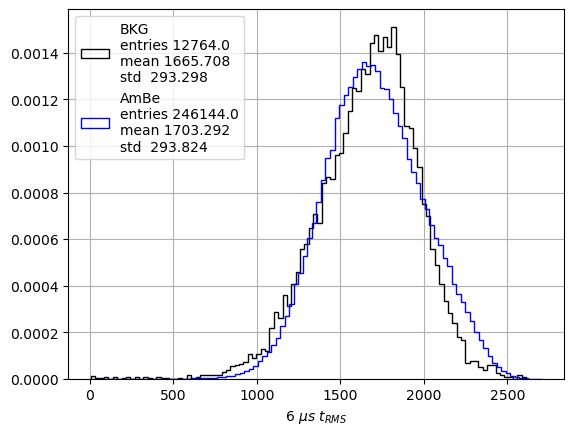

In [88]:
pltext.hist(bkg__rms_6, 100, density=True, xylabels="6 $\mu s$ $t_{RMS}$", label="BKG");
pltext.hist(ambe_rms_6, 100, density=True, xylabels="6 $\mu s$ $t_{RMS}$", label="AmBe");

#### 4 $\mu s$

##### Hist Separation

In [ ]:
bkg__mask_4 = [(bkg__no_hits_perRW > 950) & (bkg__no_hits_perRW < 1500)]
ambe_mask_4 = [(ambe_no_hits_perRW > 950) & (ambe_no_hits_perRW < 1500)]
bkg__no_hits_per_bin_4 = np.concatenate([np.histogram(bkg_run_times_sorted[ev],  np.arange(0, 270e3, 4e3))[0] for ev in tqdm(range(len(bkg_run_times_sorted[bkg__mask_4[0]])),  total=len(bkg_run_times_sorted[bkg__mask_4[0]]))])
ambe_no_hits_per_bin_4 = np.concatenate([np.histogram(ambe_run_times_sorted[ev], np.arange(0, 270e3, 4e3))[0] for ev in tqdm(range(len(ambe_run_times_sorted[ambe_mask_4[0]])), total=len(ambe_run_times_sorted[ambe_mask_4[0]]))])

  0%|          | 0/4446 [00:00<?, ?it/s]

  0%|          | 0/14990 [00:00<?, ?it/s]

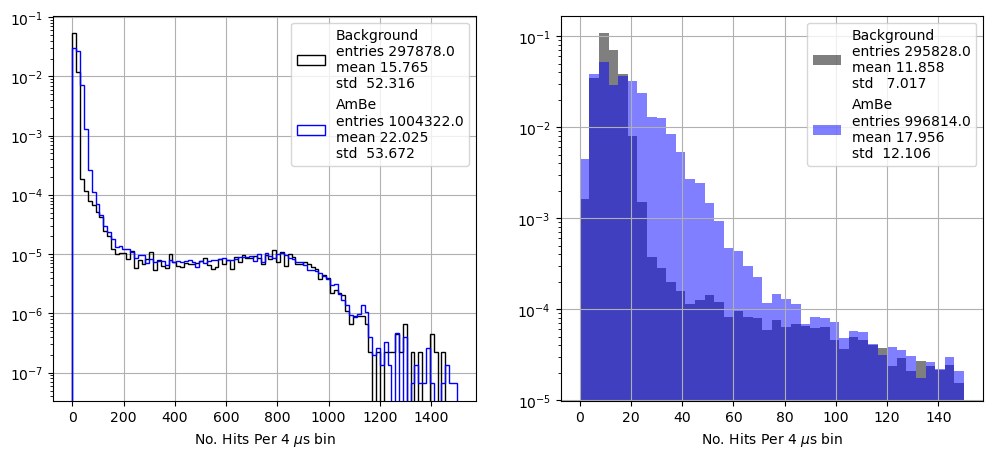

In [ ]:
subplot = pltext.canvas(2)
bin_width = 4

subplot(1)
pltext.hist(bkg__no_hits_per_bin_4, 100, ylog=True, range=(0, 1500), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="Background");
pltext.hist(ambe_no_hits_per_bin_4, 100, ylog=True, range=(0, 1500), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="AmBe");

subplot(2)
pltext.hist(bkg__no_hits_per_bin_4, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="Background");
pltext.hist(ambe_no_hits_per_bin_4, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="AmBe");

In [ ]:
bkg__mask_4 = [(bkg__no_hits_perRW > 950) & (bkg__no_hits_perRW < 1500)]
ambe_mask_4 = [(ambe_no_hits_perRW > 950) & (ambe_no_hits_perRW < 1500)]
bkg__corrected_no_hits_per_bin_4 = np.concatenate([np.histogram(bkg__corrected_run_times_sorted[ev], np.arange(0, 270e3, 4e3))[0] for ev in tqdm(range(len(bkg__corrected_run_times_sorted[bkg__mask_4[0]])), total=len(bkg__corrected_run_times_sorted[bkg__mask_4[0]]))])
ambe_corrected_no_hits_per_bin_4 = np.concatenate([np.histogram(ambe_corrected_run_times_sorted[ev], np.arange(0, 270e3, 4e3))[0] for ev in tqdm(range(len(ambe_corrected_run_times_sorted[ambe_mask_4[0]])), total=len(ambe_corrected_run_times_sorted[ambe_mask_4[0]]))])

  0%|          | 0/4446 [00:00<?, ?it/s]

  0%|          | 0/14990 [00:00<?, ?it/s]

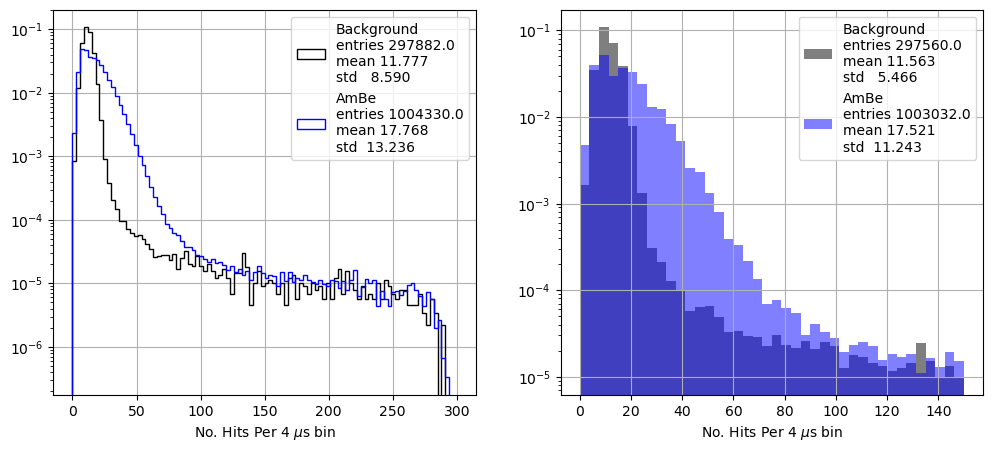

In [ ]:
subplot = pltext.canvas(2)
bin_width = 4

subplot(1)
c41, b41, _41 = pltext.hist(bkg__corrected_no_hits_per_bin_4, 100, ylog=True, range=(0, 300), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="Background");
c42, b42, _42 = pltext.hist(ambe_corrected_no_hits_per_bin_4, 100, ylog=True, range=(0, 300), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="AmBe");

subplot(2)
pltext.hist(bkg__corrected_no_hits_per_bin_4, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="Background");
pltext.hist(ambe_corrected_no_hits_per_bin_4, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="AmBe");

##### $t_{RMS}$

In [95]:
bkg__rms_indices_4, bkg__rms_times_4 = nHits(mode="multiple_events", hit_times=bkg__corrected_run_times_sorted[bkg__mask[0]], w=4e3, thresh_min=20, thresh_max=80, pre_window=0, post_window=0, jump=4e3)
ambe_rms_indices_4, ambe_rms_times_4 = nHits(mode="multiple_events", hit_times=ambe_corrected_run_times_sorted[ambe_mask[0]], w=4e3, thresh_min=20, thresh_max=80, pre_window=0, post_window=0, jump=4e3)

bkg__rms_4 = []
bkg__triggered_times = bkg__rms_times_4
for k,v in tqdm(bkg__triggered_times.items(), total=len(bkg__triggered_times.items())):
    for i in bkg__triggered_times.get(k):
        bkg__rms_4.append(rms(i))

ambe_rms_4 = []
ambe_triggered_times = ambe_rms_times_4
for k,v in tqdm(ambe_triggered_times.items(), total=len(ambe_triggered_times.items())):
    for i in ambe_triggered_times.get(k):
        ambe_rms_4.append(rms(i))

100%|██████████| 14990/14990 [00:11<00:00, 1286.92it/s]


  0%|          | 0/4392 [00:00<?, ?it/s]

  0%|          | 0/14990 [00:00<?, ?it/s]

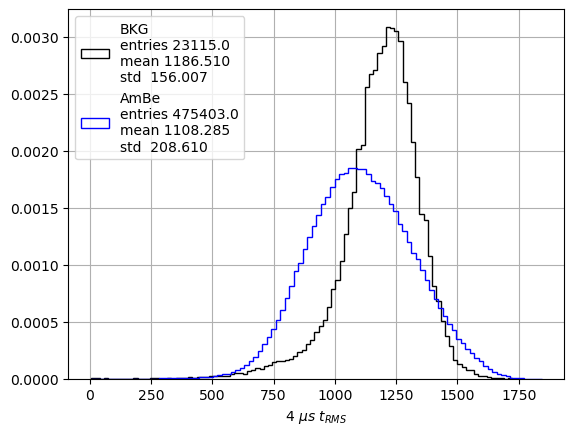

In [96]:
pltext.hist(bkg__rms_4, 100, density=True, xylabels="4 $\mu s$ $t_{RMS}$", label="BKG");
pltext.hist(ambe_rms_4, 100, density=True, xylabels="4 $\mu s$ $t_{RMS}$", label="AmBe");

##### $P$(AmBe | $n_1 \le n \le n_2$)

El bin con mayor pureza AmBe es el centrado en 286.5 hits
Pureza máxima: 100.00%


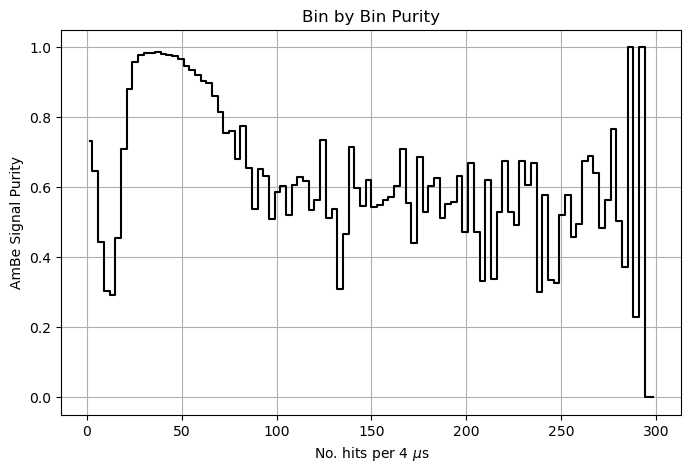

In [105]:
# Parámetros del histograma
bin_width   = b41[1] - b41[0]
bin_centers = b41[:-1] + bin_width / 2

# Calcula pureza bin a bin
S = c42 * bin_width  # Probabilidad en el bin
B = c41 * bin_width

with np.errstate(divide='ignore', invalid='ignore'):
    P_AmBe = S / (S + B)
    P_AmBe = np.nan_to_num(P_AmBe, nan=0.0)  # En caso de 0/0 o nan

# Encuentra el máximo
max_idx          = np.argmax(P_AmBe)
best_nhit_center = bin_centers[max_idx]
best_purity      = P_AmBe[max_idx]

print(f"El bin con mayor pureza AmBe es el centrado en {best_nhit_center:.1f} hits")
print(f"Pureza máxima: {best_purity*100:.2f}%")

# Plotea
plt.figure(figsize=(8,5))
plt.plot(bin_centers, P_AmBe, drawstyle='steps-mid')
plt.xlabel('No. hits per 4 $\mu$s')
plt.ylabel('AmBe Signal Purity')
plt.title('Bin by Bin Purity')
plt.grid(True)

In [78]:
bin_centers[P_AmBe > 0.95]

array([ 25.5,  28.5,  31.5,  34.5,  37.5,  40.5,  43.5,  46.5,  49.5,
       286.5, 292.5])

#### 2.5 $\mu s$

In [31]:
bkg__mask = [(bkg__no_hits_perRW > 750) & (bkg__no_hits_perRW < 1500)]
ambe_mask = [(ambe_no_hits_perRW > 750) & (ambe_no_hits_perRW < 1500)]
bkg__no_hits_per_bin = np.concatenate([np.histogram(bkg_run_times_sorted[ev],  np.arange(0, 270e3, 2.5e3))[0] for ev in tqdm(range(len(bkg_run_times_sorted[bkg__mask[0]])),  total=len(bkg_run_times_sorted[bkg__mask[0]]))])
ambe_no_hits_per_bin = np.concatenate([np.histogram(ambe_run_times_sorted[ev], np.arange(0, 270e3, 2.5e3))[0] for ev in tqdm(range(len(ambe_run_times_sorted[ambe_mask[0]])), total=len(ambe_run_times_sorted[ambe_mask[0]]))])

  0%|          | 0/13724 [00:00<?, ?it/s]

  0%|          | 0/15298 [00:00<?, ?it/s]

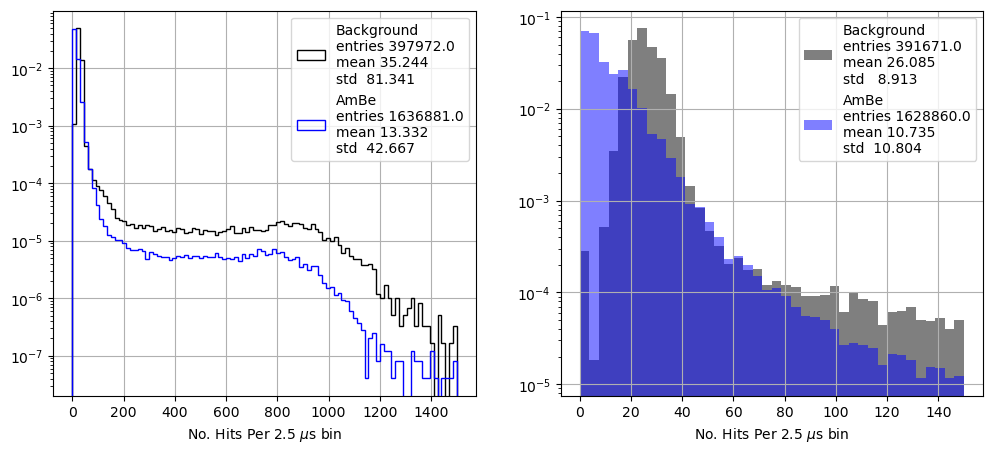

In [32]:
subplot = pltext.canvas(2)
bin_width = 2.5

subplot(1)
pltext.hist(bkg_no_hits_per_bin,  100, ylog=True, range=(0, 1500), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="Background");
pltext.hist(ambe_no_hits_per_bin, 100, ylog=True, range=(0, 1500), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="AmBe");

subplot(2)
pltext.hist(bkg_no_hits_per_bin,  40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="Background");
pltext.hist(ambe_no_hits_per_bin, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="AmBe");

In [97]:
bkg__mask = [(bkg__no_hits_perRW > 750) & (bkg__no_hits_perRW < 1500)]
ambe_mask = [(ambe_no_hits_perRW > 750) & (ambe_no_hits_perRW < 1500)]
bkg__corrected_no_hits_per_bin = np.concatenate([np.histogram(bkg__corrected_run_times_sorted[ev], np.arange(0, 270e3, 2.5e3))[0] for ev in tqdm(range(len(bkg__corrected_run_times_sorted[bkg__mask[0]])), total=len(bkg__corrected_run_times_sorted[bkg__mask[0]]))])
ambe_corrected_no_hits_per_bin = np.concatenate([np.histogram(ambe_corrected_run_times_sorted[ev], np.arange(0, 270e3, 2.5e3))[0] for ev in tqdm(range(len(ambe_corrected_run_times_sorted[ambe_mask[0]])), total=len(ambe_corrected_run_times_sorted[ambe_mask[0]]))])

  0%|          | 0/13724 [00:00<?, ?it/s]

  0%|          | 0/15237 [00:00<?, ?it/s]

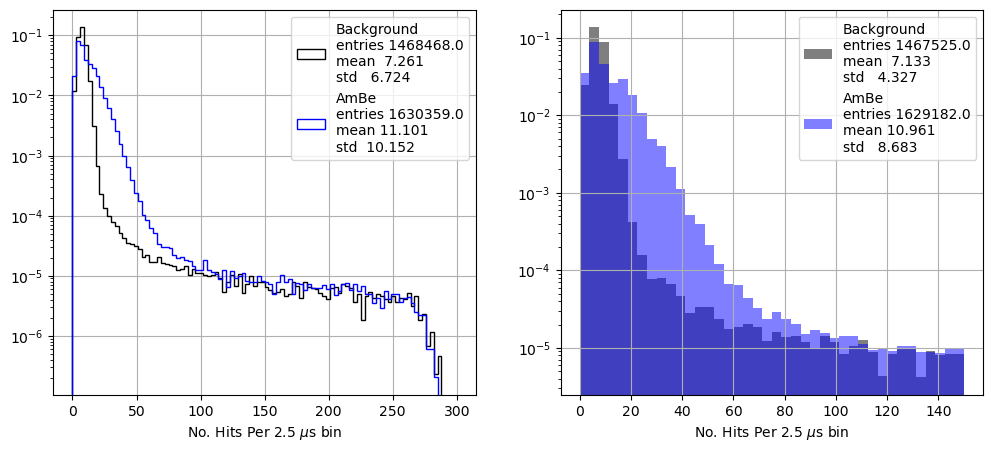

In [98]:
subplot = pltext.canvas(2)
bin_width = 2.5

subplot(1)
pltext.hist(bkg__corrected_no_hits_per_bin, 100, ylog=True, range=(0, 300), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="Background");
pltext.hist(ambe_corrected_no_hits_per_bin, 100, ylog=True, range=(0, 300), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="AmBe");

subplot(2)
pltext.hist(bkg__corrected_no_hits_per_bin, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="Background");
pltext.hist(ambe_corrected_no_hits_per_bin, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="AmBe");

In [99]:
bkg__rms_is_25,           bkg__rms_times_25 = nHits(mode="multiple_events", hit_times=bkg__corrected_run_times_sorted[bkg__mask[0]], w=2.5e3, thresh_min=20, thresh_max=60, pre_window=0, post_window=0, jump=2.5e3)
ambe_rms_indicendices_25, ambe_rms_times_25 = nHits(mode="multiple_events", hit_times=ambe_corrected_run_times_sorted[ambe_mask[0]], w=2.5e3, thresh_min=20, thresh_max=60, pre_window=0, post_window=0, jump=2.5e3)

bkg__rms_25 = []
bkg__triggered_times = bkg__rms_times_25
for k,v in tqdm(bkg__triggered_times.items(), total=len(bkg__triggered_times.items())):
    for i in bkg__triggered_times.get(k):
        bkg__rms_25.append(rms(i))

ambe_rms_25 = []
ambe_triggered_times = ambe_rms_times_25
for k,v in tqdm(ambe_triggered_times.items(), total=len(ambe_triggered_times.items())):
    for i in ambe_triggered_times.get(k):
        ambe_rms_25.append(rms(i))

100%|██████████| 15237/15237 [00:07<00:00, 1927.85it/s]


  0%|          | 0/6871 [00:00<?, ?it/s]

  0%|          | 0/15237 [00:00<?, ?it/s]

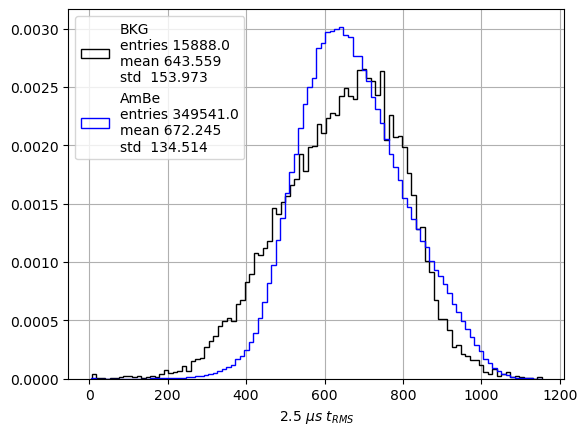

In [100]:
pltext.hist(bkg__rms_25, 100, density=True, xylabels="2.5 $\mu s$ $t_{RMS}$", label="BKG");
pltext.hist(ambe_rms_25, 100, density=True, xylabels="2.5 $\mu s$ $t_{RMS}$", label="AmBe");

#### 1.5 $\mu s$

##### Hist Separation

In [28]:
bkg__mask_15 = [(bkg__no_hits_perRW > 750) & (bkg__no_hits_perRW < 1500)]
ambe_mask_15 = [(ambe_no_hits_perRW > 750) & (ambe_no_hits_perRW < 1500)]
bkg__no_hits_per_bin_15 = np.concatenate([np.histogram(bkg_run_times_sorted[ev],  np.arange(0, 270e3, 1.5e3))[0] for ev in tqdm(range(len(bkg_run_times_sorted[bkg__mask_15[0]])),  total=len(bkg_run_times_sorted[bkg__mask_15[0]]))])
ambe_no_hits_per_bin_15 = np.concatenate([np.histogram(ambe_run_times_sorted[ev], np.arange(0, 270e3, 1.5e3))[0] for ev in tqdm(range(len(ambe_run_times_sorted[ambe_mask_15[0]])), total=len(ambe_run_times_sorted[ambe_mask_15[0]]))])

  0%|          | 0/13724 [00:00<?, ?it/s]

  0%|          | 0/15237 [00:00<?, ?it/s]

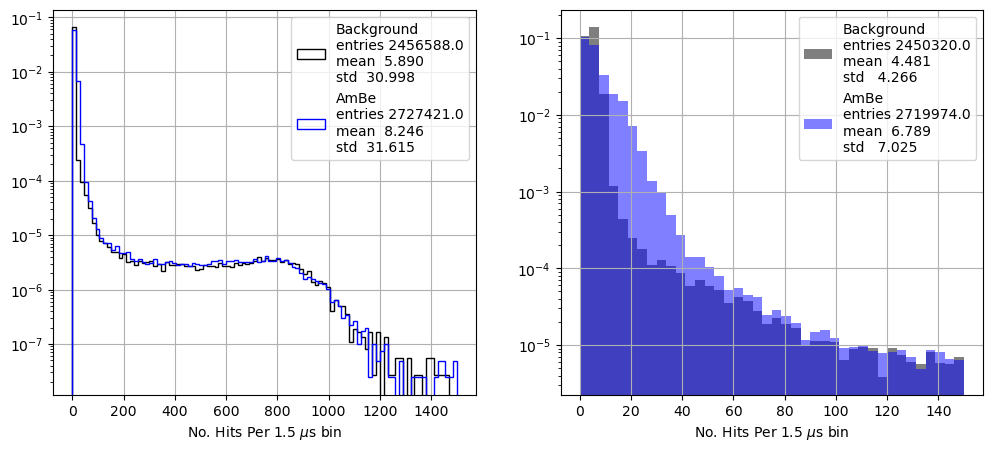

In [29]:
subplot = pltext.canvas(2)
bin_width = 1.5

subplot(1)
pltext.hist(bkg__no_hits_per_bin_15, 100, ylog=True, range=(0, 1500), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="Background");
pltext.hist(ambe_no_hits_per_bin_15, 100, ylog=True, range=(0, 1500), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="AmBe");

subplot(2)
pltext.hist(bkg__no_hits_per_bin_15, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="Background");
pltext.hist(ambe_no_hits_per_bin_15, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="AmBe");

In [30]:
bkg__mask_15 = [(bkg__no_hits_perRW > 750) & (bkg__no_hits_perRW < 1500)]
ambe_mask_15 = [(ambe_no_hits_perRW > 750) & (ambe_no_hits_perRW < 1500)]
bkg__corrected_no_hits_per_bin_15 = np.concatenate([np.histogram(bkg__corrected_run_times_sorted[ev], np.arange(0, 270e3, 1.5e3))[0] for ev in tqdm(range(len(bkg__corrected_run_times_sorted[bkg__mask_15[0]])), total=len(bkg__corrected_run_times_sorted[bkg__mask_15[0]]))])
ambe_corrected_no_hits_per_bin_15 = np.concatenate([np.histogram(ambe_corrected_run_times_sorted[ev], np.arange(0, 270e3, 1.5e3))[0] for ev in tqdm(range(len(ambe_corrected_run_times_sorted[ambe_mask_15[0]])), total=len(ambe_corrected_run_times_sorted[ambe_mask_15[0]]))])

  0%|          | 0/13724 [00:00<?, ?it/s]

  0%|          | 0/15237 [00:00<?, ?it/s]

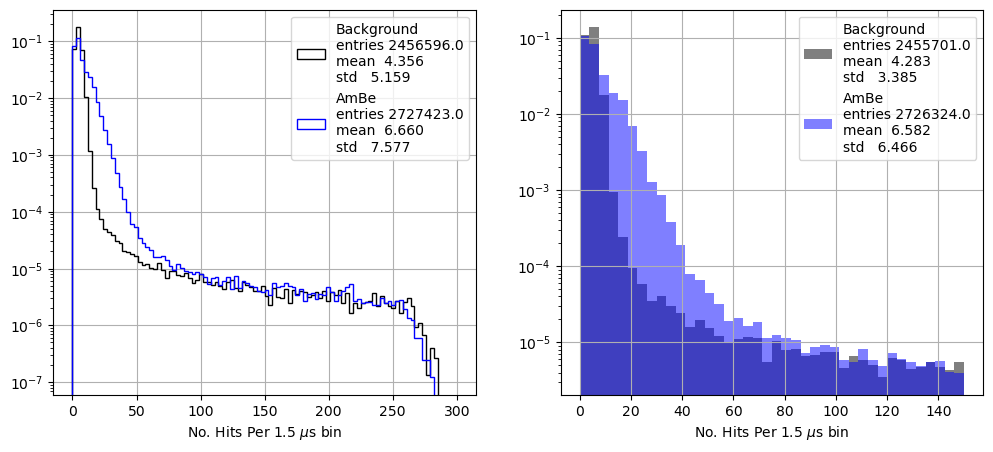

In [61]:
subplot = pltext.canvas(2)
bin_width = 1.5

subplot(1)
c151, b151, _151 = pltext.hist(bkg__corrected_no_hits_per_bin_15, 100, ylog=True, range=(0, 300), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="Background");
c152, b152, _152 = pltext.hist(ambe_corrected_no_hits_per_bin_15, 100, ylog=True, range=(0, 300), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", label="AmBe");

subplot(2)
pltext.hist(bkg__corrected_no_hits_per_bin_15, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="Background");
pltext.hist(ambe_corrected_no_hits_per_bin_15, 40, ylog=True, range=(0, 150), density=True, xylabels=f"No. Hits Per {bin_width} $\mu$s bin", histtype="stepfilled", alpha=0.5, label="AmBe");

##### $t_{RMS}$

In [105]:
bkg__rms_is_15,           bkg__rms_times_15 = nHits(mode="multiple_events", hit_times=bkg__corrected_run_times_sorted[bkg__mask[0]], w=1.5e3, thresh_min=15, thresh_max=50, pre_window=0, post_window=0, jump=1.5e3)
ambe_rms_indicendices_15, ambe_rms_times_15 = nHits(mode="multiple_events", hit_times=ambe_corrected_run_times_sorted[ambe_mask[0]], w=1.5e3, thresh_min=15, thresh_max=50, pre_window=0, post_window=0, jump=1.5e3)

bkg__rms_15 = []
bkg__triggered_times = bkg__rms_times_15
for k,v in tqdm(bkg__triggered_times.items(), total=len(bkg__triggered_times.items())):
    for i in bkg__triggered_times.get(k):
        bkg__rms_15.append(rms(i))

ambe_rms_15 = []
ambe_triggered_times = ambe_rms_times_15
for k,v in tqdm(ambe_triggered_times.items(), total=len(ambe_triggered_times.items())):
    for i in ambe_triggered_times.get(k):
        ambe_rms_15.append(rms(i))

100%|██████████| 15237/15237 [00:08<00:00, 1697.18it/s]


  0%|          | 0/7377 [00:00<?, ?it/s]

  0%|          | 0/15237 [00:00<?, ?it/s]

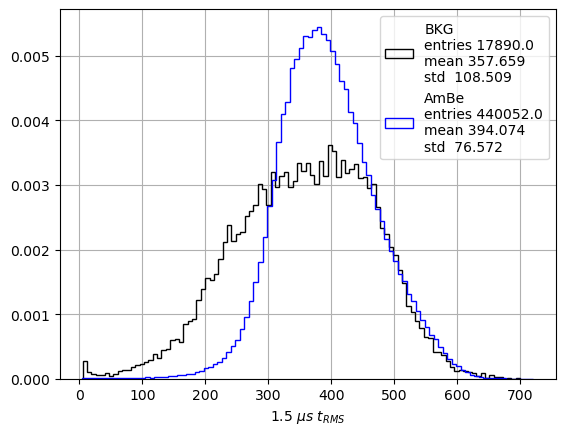

In [106]:
pltext.hist(bkg__rms_15, 100, density=True, xylabels="1.5 $\mu s$ $t_{RMS}$", label="BKG");
pltext.hist(ambe_rms_15, 100, density=True, xylabels="1.5 $\mu s$ $t_{RMS}$", label="AmBe");

##### $P$(AmBe | $n_1 \le n \le n_2$)

El bin con mayor pureza AmBe es el centrado en 19.5 hits
Pureza máxima: 98.74%


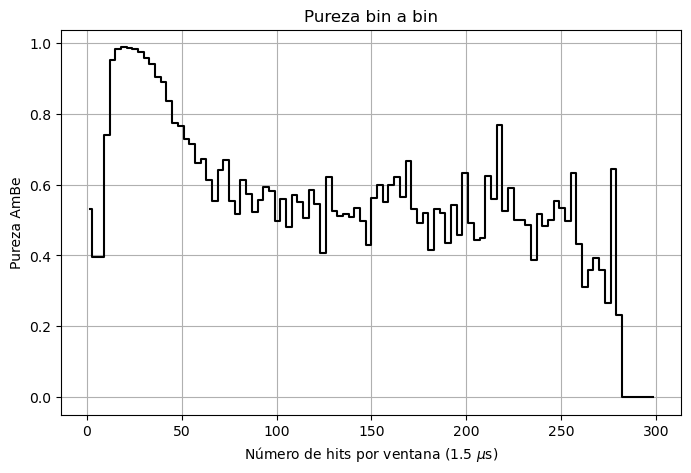

In [62]:
# Parámetros del histograma
bin_width   = b151[1] - b151[0]
bin_centers = b151[:-1] + bin_width / 2

# Calcula pureza bin a bin
S = c152 * bin_width  # Probabilidad en el bin
B = c151 * bin_width

with np.errstate(divide='ignore', invalid='ignore'):
    P_AmBe = S / (S + B)
    P_AmBe = np.nan_to_num(P_AmBe, nan=0.0)  # En caso de 0/0 o nan

# Encuentra el máximo
max_idx          = np.argmax(P_AmBe)
best_nhit_center = bin_centers[max_idx]
best_purity      = P_AmBe[max_idx]

print(f"El bin con mayor pureza AmBe es el centrado en {best_nhit_center:.1f} hits")
print(f"Pureza máxima: {best_purity*100:.2f}%")

# Plotea
plt.figure(figsize=(8,5))
plt.plot(bin_centers, P_AmBe, drawstyle='steps-mid')
plt.xlabel('Número de hits por ventana (1.5 $\mu$s)')
plt.ylabel('Pureza AmBe')
plt.title('Pureza bin a bin')
plt.grid(True)

In [37]:
bin_centers[P_AmBe > 0.95]

array([13.125, 16.875, 20.625, 24.375, 28.125, 31.875])

### Studies Applying The nHits Algorithm. Characterization Of The Triggered Signal.

In [79]:
bkg__triggered_scint_hits_index = nHits(mode="multiple_events", hit_times=bkg__corrected_run_times_sorted, w=4000, thresh_min=26, thresh_max=40, pre_window=0, post_window=0, jump=4000)
ambe_triggered_scint_hits_index = nHits(mode="multiple_events", hit_times=ambe_corrected_run_times_sorted, w=4000, thresh_min=26, thresh_max=40, pre_window=0, post_window=0, jump=4000)

100%|██████████| 22892/22892 [00:13<00:00, 1759.14it/s]


#### Cantas veces trigga no centelleo o algoritmo?

In [80]:
bkg__total_no_scint_triggers = [len(bkg__triggered_scint_hits_index[0].get(key)) for key, value in bkg__triggered_scint_hits_index[0].items()]
ambe_total_no_scint_triggers = [len(ambe_triggered_scint_hits_index[0].get(key)) for key, value in ambe_triggered_scint_hits_index[0].items()]

In [81]:
np.sum(bkg__total_no_scint_triggers), np.sum(ambe_total_no_scint_triggers)

(30905, 454173)

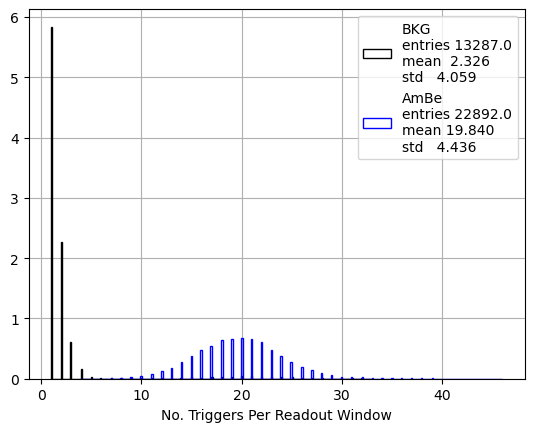

In [84]:
pltext.hist(bkg__total_no_scint_triggers, 300, ylog=False, density=True, xylabels="No. Triggers Per Readout Window", label="BKG");
pltext.hist(ambe_total_no_scint_triggers, 300, ylog=False, density=True, xylabels="No. Triggers Per Readout Window", label="AmBe");

In [28]:
thresholds = np.arange(50, 250, 10)
sum_scint_bkg  = []
sum_scint_ambe = []

for th in tqdm(thresholds, total=len(thresholds)):
    bkg_triggered_scint_hits_index  = nHits(mode="multiple_events", hit_times=bkg_corrected_run_times_sorted,  w=1500, thresh_min=th, thresh_max=np.inf, pre_window=0, post_window=50, jump=1550, progress_bar=False)
    ambe_triggered_scint_hits_index = nHits(mode="multiple_events", hit_times=ambe_corrected_run_times_sorted, w=1500, thresh_min=th, thresh_max=np.inf, pre_window=0, post_window=50, jump=1550, progress_bar=False)

    bkg_total_no_scint_triggers  = [len(bkg_triggered_scint_hits_index.get(key)) for key, value in bkg_triggered_scint_hits_index.items()]
    ambe_total_no_scint_triggers = [len(ambe_triggered_scint_hits_index.get(key)) for key, value in ambe_triggered_scint_hits_index.items()]

    sum_scint_bkg.append(np.sum(bkg_total_no_scint_triggers))
    sum_scint_ambe.append(np.sum(ambe_total_no_scint_triggers))

  0%|          | 0/20 [00:00<?, ?it/s]

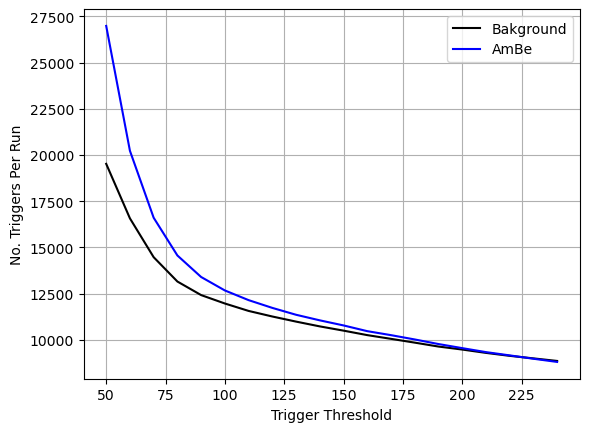

In [29]:
plt.plot(thresholds, sum_scint_bkg,  label="Bakground");
plt.plot(thresholds, sum_scint_ambe, label="AmBe");

plt.xlabel("Trigger Threshold")
plt.ylabel("No. Triggers Per Run")

plt.grid(True)

plt.legend();

### Characterization Of Triggered Scintillation Signal

In [85]:
bkg__triggered_scint_hits_index = nHits(mode="multiple_events", hit_times=bkg__corrected_run_times_sorted, w=4000, thresh_min=26, thresh_max=40, pre_window=0, post_window=0, jump=4000)
ambe_triggered_scint_hits_index = nHits(mode="multiple_events", hit_times=ambe_corrected_run_times_sorted, w=4000, thresh_min=26, thresh_max=40, pre_window=0, post_window=0, jump=4000)

 21%|██        | 5278/25315 [00:00<00:02, 6747.99it/s]

100%|██████████| 22892/22892 [00:13<00:00, 1678.57it/s]


In [86]:
ambe_triggered_scint_hits_index[0].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

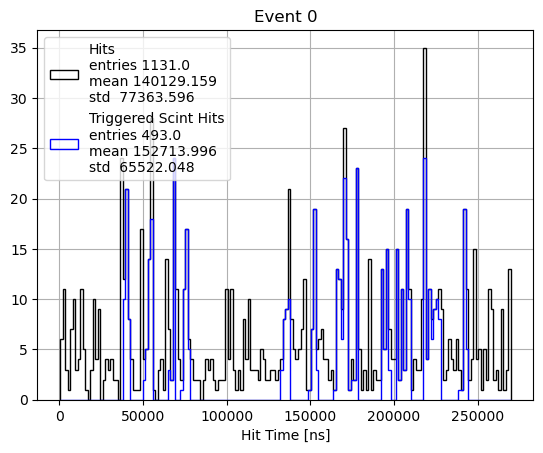

In [87]:
event = 0
data  = ambe_corrected_run_times_sorted[event]

pltext.hist(data,                                                                180, range=(data[0], data[-1]), xylabels="Hit Time [ns]", label=f"Hits");
pltext.hist(data[np.concatenate(ambe_triggered_scint_hits_index[0].get(event))], 180, range=(data[0], data[-1]), xylabels="Hit Time [ns]", label=f"Triggered Scint Hits");

plt.title(f"Event {event}");

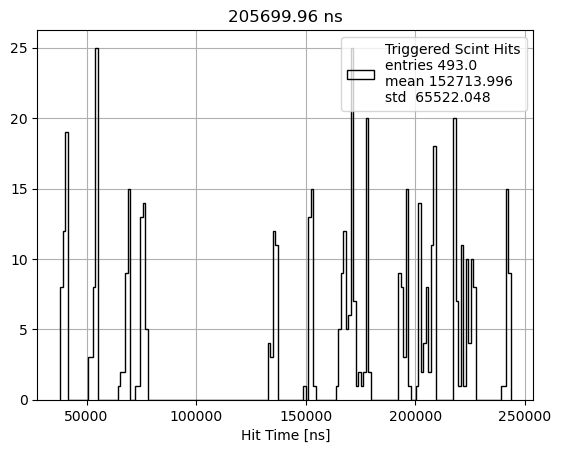

In [88]:
pltext.hist(data[np.concatenate(ambe_triggered_scint_hits_index[0].get(event))], 180,  xylabels="Hit Time [ns]", label=f"Triggered Scint Hits");
plt.title(f"{data[np.concatenate(ambe_triggered_scint_hits_index[0].get(event))][-1] - data[np.concatenate(ambe_triggered_scint_hits_index[0].get(event))][0]:.2f} ns");

In [89]:
def scint_characterization(trigger_indices, data):
    no_scint_hits     = []
    scint_pulse_width = []
    for key, values in tqdm(trigger_indices.items(), total=len(trigger_indices.items())):
        event_data = data[key]
        for i in trigger_indices.get(key):
            triggered_hits = event_data[trigger_indices.get(key)[0]]

            no_scint_hits    .append(len(triggered_hits)) 
            scint_pulse_width.append(triggered_hits[-1] - triggered_hits[0])
    
    return no_scint_hits, scint_pulse_width

In [90]:
bkg__no_scint_hits, bkg__scint_pulse_width = scint_characterization(bkg__triggered_scint_hits_index[0], bkg__corrected_run_times_sorted)
ambe_no_scint_hits, ambe_scint_pulse_width = scint_characterization(ambe_triggered_scint_hits_index[0], ambe_corrected_run_times_sorted)

  0%|          | 0/13287 [00:00<?, ?it/s]

  0%|          | 0/22892 [00:00<?, ?it/s]

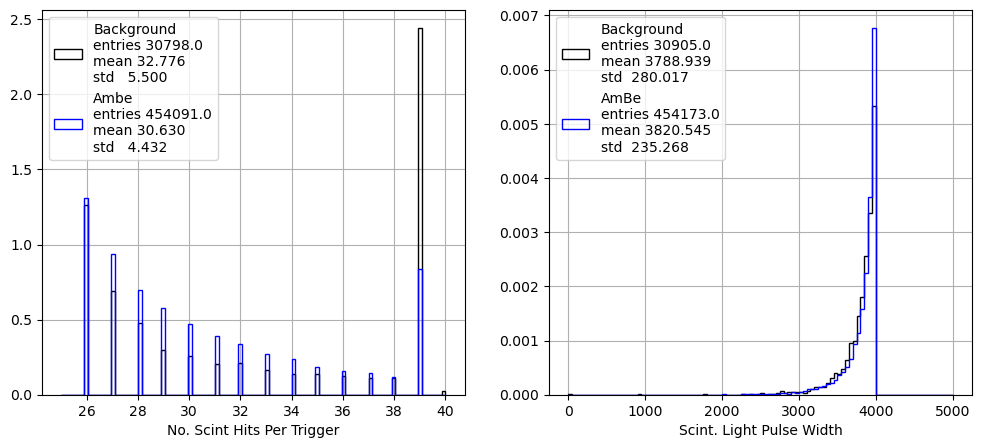

In [95]:
subplot = pltext.canvas(2)

subplot(1)
pltext.hist(bkg__no_scint_hits, 100, range=(25, 40), density=True, ylog=False ,xylabels="No. Scint Hits Per Trigger", label="Background");
pltext.hist(ambe_no_scint_hits, 100, range=(25, 40), density=True, ylog=False ,xylabels="No. Scint Hits Per Trigger", label="Ambe");

subplot(2)
pltext.hist(bkg__scint_pulse_width, 100, range=(0, 5000), density=True, xylabels="Scint. Light Pulse Width", label="Background");
pltext.hist(ambe_scint_pulse_width, 100, range=(0, 5000), density=True, xylabels="Scint. Light Pulse Width", label="AmBe");

In [70]:
bkg__triggered_scint_hits_index[0].keys()

dict_keys([0, 1, 2, 3, 4, 7, 8, 10, 12, 13, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 45, 46, 48, 49, 50, 51, 52, 53, 54, 57, 58, 60, 62, 65, 69, 70, 72, 73, 74, 76, 77, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 102, 103, 104, 105, 106, 108, 110, 111, 112, 113, 115, 118, 119, 120, 121, 122, 123, 126, 127, 128, 129, 130, 133, 135, 136, 138, 139, 140, 141, 142, 144, 146, 147, 148, 149, 152, 153, 154, 155, 156, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 204, 208, 209, 210, 215, 216, 217, 219, 220, 223, 224, 225, 226, 227, 229, 230, 231, 233, 234, 237, 238, 239, 240, 241, 242, 243, 245, 247, 248, 249, 250, 251, 252, 253, 254, 257, 258, 259, 260, 261, 262, 263, 264, 265, 267, 268, 269, 270, 271, 272, 273, 275, 276, 277, 278, 279, 281, 28

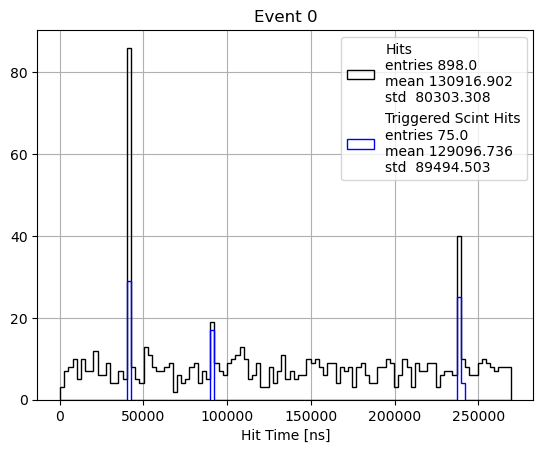

In [72]:
event = 0
data  = bkg__corrected_run_times_sorted[event]

pltext.hist(data,                                                               108, range=(data[0], data[-1]), xylabels="Hit Time [ns]", label=f"Hits");
pltext.hist(data[np.concatenate(bkg_triggered_scint_hits_index[0].get(event))], 108, range=(data[0], data[-1]), xylabels="Hit Time [ns]", label=f"Triggered Scint Hits");

plt.title(f"Event {event}");

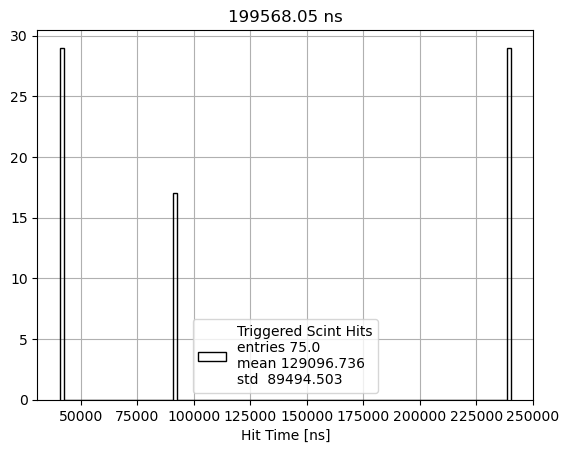

In [73]:
pltext.hist(data[np.concatenate(bkg_triggered_scint_hits_index[0].get(event))], 108,  xylabels="Hit Time [ns]", label=f"Triggered Scint Hits");
plt.title(f"{data[np.concatenate(bkg_triggered_scint_hits_index[0].get(event))][-1] - data[np.concatenate(bkg_triggered_scint_hits_index[0].get(event))][0]:.2f} ns");

In [40]:
no_scint_hits     = []
scint_pulse_width = []
for key, values in tqdm(bkg_triggered_scint_hits_index.items(), total=len(bkg_triggered_scint_hits_index.items())):
    data = bkg_corrected_run_times_sorted[key]
    for i in bkg_triggered_scint_hits_index.get(key):
        triggered_hits = data[bkg_triggered_scint_hits_index.get(key)[0]]

        no_scint_hits    .append(len(triggered_hits)) 
        scint_pulse_width.append(triggered_hits[-1] - triggered_hits[0])

  0%|          | 0/13410 [00:00<?, ?it/s]

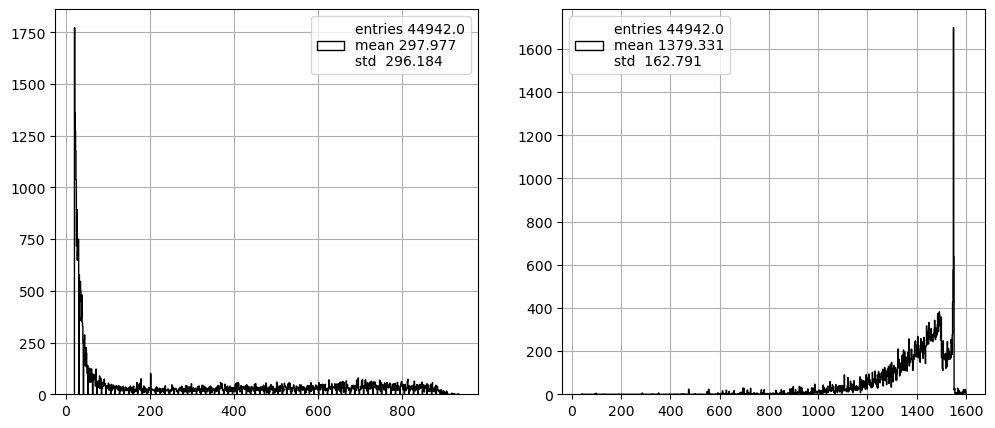

In [41]:
subplot = pltext.canvas(2)

subplot(1)
pltext.hist(no_scint_hits, 1000);

subplot(2)
pltext.hist(scint_pulse_width, 1000);

# Explicit $t_{RMS}$ Study